In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
set_config(display='diagram')

### Canonizer sklearn svm pipeline

In [38]:
def canonizer(data, test_size=0.2, random_state=42, sampling=None, cross_validation=False, cv=5, kernel='rbf', nb_coef=20):
    
    df_results = pd.DataFrame()
    
    if cross_validation == True:
        pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
        cv_results = cross_validate(pipe, data.drop(['canon'], axis=1), data['canon'], cv=cv)
        return pipe, cv_results
    
    else:
        if kernel == 'rbf':
            pipe = make_pipeline(StandardScaler(), Normalizer(), SVC(kernel=kernel, probability=True))
        else:
            pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
    

        X_train, X_test, y_train, y_test = train_test_split(data.drop(['canon'], axis=1), data['canon'], test_size=test_size, random_state=random_state)
        print('Original dataset shape {}'.format(Counter(y_train)))
        
        if sampling is not None:     
            if sampling == 'over':
                ros = RandomOverSampler(random_state=10)
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                
            elif sampling == 'under':
                rus = RandomUnderSampler(random_state=10)
                X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
                
            elif sampling == "smoteenn":
                smote_enn = SMOTEENN(random_state=10)
                X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
                
            elif sampling == 'smotetomek':
                smote_tomek = SMOTETomek(random_state=10)
                X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
            
            else:
                print('Please follow the sampling possible values : over, under, smoteenn, smotetomek')
                return
                
            print('Resampled dataset shape {}'.format(Counter(y_resampled)))
        
            pipe.fit(X_resampled, y_resampled)
        
        else:
            pipe.fit(X_train, y_train)
        
        print(metrics.classification_report(y_test, pipe.predict(X_test)))
    
        if kernel == 'linear':
            coefs = pipe_size_opti_linear.named_steps['svc'].coef_
            plot_coefficients(*coefs, data.columns, nb_coef)
            
        df_results['metadata'] = y_test
        df_results['proba canon'] = pipe.predict_proba(X_test)[:,0]
        df_results['proba non-canon'] = pipe.predict_proba(X_test)[:,1]
        df_results['prediction']= pipe.predict(X_test)
    
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
    
    
    return pipe, df_results

In [5]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Meilleurs coefficients pour la classification binaire")
    plt.savefig('img/coefs_linear_svm.png')
    plt.show()

### Load df features main metadata

In [6]:
df_main = pd.read_csv(r'data\features_canon.csv')
df_main.set_index("index", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [7]:
df_main['canon'].value_counts(normalize=True)

non_canon    0.911824
canon        0.088176
Name: canon, dtype: float64

In [7]:
pipe_main, df_results_main = canonizer(df_main)

Original dataset shape Counter({'non_canon': 2162, 'canon': 206})
              precision    recall  f1-score   support

       canon       1.00      0.09      0.17        55
   non_canon       0.91      1.00      0.96       537

    accuracy                           0.92       592
   macro avg       0.96      0.55      0.56       592
weighted avg       0.92      0.92      0.88       592



In [8]:
df_results_main

,metadata,proba canon,proba non-canon,prediction,accord
index,,,,,
1973_Vautrin-Jean_a-Bulletins-Rouges,non_canon,0.094963,0.905037,non_canon,True
1903_Chabrier-Rieder-Charlotte_Les-Enfants-du-Luxembourg,non_canon,0.021640,0.978360,non_canon,True
1879_Thuret-Mme-E._La-Guerre-au-chateau,non_canon,0.046761,0.953239,non_canon,True
1954_Reage-Pauline_Histoire-d-O,non_canon,0.197713,0.802287,non_canon,True
1928_Cami-Pierre-Henri_le-jugement-dernier,non_canon,0.031597,0.968403,non_canon,True
...,...,...,...,...,...
1869_Carraud-Zulma-Tourangin-Mme_Les-Gouters-de-la-grand-mere,non_canon,0.027756,0.972244,non_canon,True
1831_Signol-Alphonse-Macaire-Stanislas_Le-Chiffonnier_Tome-1,non_canon,0.073798,0.926202,non_canon,True
1950_Delly_Le-violon-du-tzigane,non_canon,0.020972,0.979028,non_canon,True


### SIZE OPTI (4/6)

In [8]:
df_size_opti = pd.read_csv(r'data\df_size_opti.csv')
df_size_opti.set_index("index", inplace = True)
df_size_opti = df_size_opti.replace(np.nan, 0)
len(df_size_opti)

640

In [9]:
df_size_opti['canon'].value_counts(normalize=True)

non_canon    0.592187
canon        0.407813
Name: canon, dtype: float64

Original dataset shape Counter({'non_canon': 339, 'canon': 237})
Resampled dataset shape Counter({'non_canon': 339, 'canon': 339})
              precision    recall  f1-score   support

       canon       0.62      0.62      0.62        24
   non_canon       0.78      0.78      0.78        40

    accuracy                           0.72        64
   macro avg       0.70      0.70      0.70        64
weighted avg       0.72      0.72      0.72        64



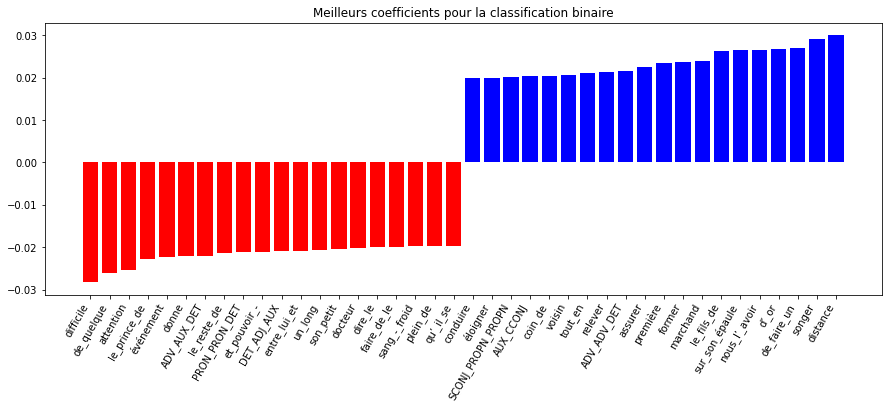

In [146]:
pipe_size_opti_linear, df_results_size_opti_linear = canonizer(df_size_opti, test_size=0.1, kernel='linear', sampling='over')

In [163]:
df_main_balanced = pd.read_csv(r'data\features_balanced.csv')
df_main_balanced.set_index("index", inplace = True)
df_main_balanced = df_main_balanced.replace(np.nan, 0)

In [164]:
pipe_size_opti, df_results_size_opti = canonizer(df_main_balanced)

Original dataset shape Counter({'non_canon': 209, 'canon': 208})
              precision    recall  f1-score   support

       canon       0.70      0.87      0.77        53
   non_canon       0.82      0.62      0.70        52

    accuracy                           0.74       105
   macro avg       0.76      0.74      0.74       105
weighted avg       0.76      0.74      0.74       105



In [111]:
pipe_size_opti, df_results_size_opti = canonizer(df_size_opti)

Original dataset shape Counter({'non_canon': 297, 'canon': 215})
              precision    recall  f1-score   support

       canon       0.64      0.74      0.69        46
   non_canon       0.84      0.77      0.80        82

    accuracy                           0.76       128
   macro avg       0.74      0.75      0.74       128
weighted avg       0.77      0.76      0.76       128



In [50]:
pipe_size_opti_over_sampled, df_results_size_opti_over_sampled = canonizer(df_size_opti, kernel='poly', sampling='over')

Original dataset shape Counter({'non_canon': 297, 'canon': 215})
Resampled dataset shape Counter({'canon': 297, 'non_canon': 297})
              precision    recall  f1-score   support

       canon       0.79      0.57      0.66        46
   non_canon       0.79      0.91      0.85        82

    accuracy                           0.79       128
   macro avg       0.79      0.74      0.75       128
weighted avg       0.79      0.79      0.78       128



### Cross_validation

In [35]:
pipe_size_opti_cv, df_results_size_opti_cv = canonizer(df_size_opti, cross_validation=True)

In [32]:
df_results_size_opti_cv

{'fit_time': array([6.07348347, 6.24646616, 4.64034796, 4.15130806, 5.79043245]),
 'score_time': array([0.31302357, 0.3550272 , 0.36602855, 0.29302025, 0.29602242]),
 'test_score': array([0.734375 , 0.6953125, 0.7109375, 0.84375  , 0.7734375])}

In [34]:
sum(df_results_size_opti_cv['test_score'])/len(df_results_size_opti_cv['test_score'])

0.7515625

In [153]:
lists_canonique = list(df_fabula['canon'])

In [158]:
df_1000 = df_fabula.iloc[:, :1000]

In [159]:
df_1000['canon']=lists_canonique

In [161]:
pipe_test, df_results_test = canonizer(df_100, sampling='over')

Original dataset shape Counter({False: 1425, True: 943})
Resampled dataset shape Counter({True: 1425, False: 1425})
              precision    recall  f1-score   support

       False       0.92      0.88      0.90       380
        True       0.80      0.87      0.83       212

    accuracy                           0.88       592
   macro avg       0.86      0.87      0.87       592
weighted avg       0.88      0.88      0.88       592



In [162]:
pipe_test, df_results_test = canonizer(df_1000, sampling='over')

Original dataset shape Counter({False: 1425, True: 943})
Resampled dataset shape Counter({True: 1425, False: 1425})
              precision    recall  f1-score   support

       False       0.93      0.91      0.92       380
        True       0.84      0.87      0.86       212

    accuracy                           0.90       592
   macro avg       0.88      0.89      0.89       592
weighted avg       0.90      0.90      0.90       592



In [156]:
pipe_test, df_results_test = canonizer(df_1000)

Original dataset shape Counter({'non_canon': 297, 'canon': 215})
              precision    recall  f1-score   support

       canon       0.60      0.80      0.69        46
   non_canon       0.86      0.70      0.77        82

    accuracy                           0.73       128
   macro avg       0.73      0.75      0.73       128
weighted avg       0.77      0.73      0.74       128



In [59]:
pipe_test, df_results_test = canonizer(df_100)

Original dataset shape Counter({'non_canon': 297, 'canon': 215})
              precision    recall  f1-score   support

       canon       0.55      0.72      0.62        46
   non_canon       0.81      0.67      0.73        82

    accuracy                           0.69       128
   macro avg       0.68      0.69      0.68       128
weighted avg       0.72      0.69      0.69       128



### Load df features one txt one author main metadata

In [60]:
df_main_ones = pd.read_csv(r'data\df_main_ones.csv')
df_main_ones.set_index("Unnamed: 0", inplace = True)
df_main_ones = df_main_ones.replace(np.nan, 0)

In [140]:
len(df_main_ones)

134

In [61]:
df_main_ones['canon'].value_counts(normalize=True)

non_canon    0.574627
canon        0.425373
Name: canon, dtype: float64

In [112]:
pipe_main_ones, df_results_main_ones = canonizer(df_main_ones)

Original dataset shape Counter({'non_canon': 60, 'canon': 47})
              precision    recall  f1-score   support

       canon       0.58      0.70      0.64        10
   non_canon       0.80      0.71      0.75        17

    accuracy                           0.70        27
   macro avg       0.69      0.70      0.69        27
weighted avg       0.72      0.70      0.71        27



In [195]:
df_results_main_ones

,metadata,proba canon,proba non-canon,prediction,accord
Unnamed: 0,,,,,
1863_Roy-Just-Jean-Etienne_Un-tableau-de-la-Sainte-Vierge,non_canon,0.366259,0.633741,non_canon,True
1950_Duras-Marguerite_Un-barrage-contre-le-Pacifique,canon,0.713165,0.286835,canon,True
1876_Escoffier-Henri_Les-femmes-fatales,non_canon,0.114960,0.885040,non_canon,True
2010_Houellebecq-Michel_La-Carte-et-le-territoire,canon,0.726449,0.273551,canon,True
1864_Prost-Lacuzon-Jules_La-Tour-aux-viperes-chronique-jurassienne-du-XVe-siecle,non_canon,0.232924,0.767076,non_canon,True
1969_Marceau-Felicien_Creezy,canon,0.728662,0.271338,canon,True
2013_Fournel-Paul_La-Liseuse,non_canon,0.553278,0.446722,canon,False
1923_Radiguet-Raymond_Le-diable-au-corps,canon,0.662694,0.337306,canon,True
1907_Moselly-Emile_Terres-lorraines,canon,0.695754,0.304246,canon,True


### Load df features fabula metadata

In [116]:
df_fabula = pd.read_csv(r'data\features_fabula.csv')
df_fabula.set_index("index", inplace = True)
df_fabula = df_fabula.replace(np.nan, 0)

In [117]:
df_fabula['canon'].value_counts(normalize=True)

False    0.609797
True     0.390203
Name: canon, dtype: float64

In [120]:
pipe_fabula, df_results_fabula = canonizer(df_fabula, sampling='over', test_size=0.1)

Original dataset shape Counter({False: 1613, True: 1051})
Resampled dataset shape Counter({False: 1613, True: 1613})
              precision    recall  f1-score   support

       False       0.95      0.93      0.94       192
        True       0.88      0.90      0.89       104

    accuracy                           0.92       296
   macro avg       0.91      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



In [121]:
df_results_fabula

,metadata,proba canon,proba non-canon,prediction,accord
index,,,,,
1973_Vautrin-Jean_a-Bulletins-Rouges,False,0.903066,0.096934,False,True
1903_Chabrier-Rieder-Charlotte_Les-Enfants-du-Luxembourg,False,0.993908,0.006092,False,True
1879_Thuret-Mme-E._La-Guerre-au-chateau,False,0.999595,0.000405,False,True
1954_Reage-Pauline_Histoire-d-O,True,0.074368,0.925632,True,True
1928_Cami-Pierre-Henri_le-jugement-dernier,False,0.991573,0.008427,False,True
...,...,...,...,...,...
1975_San-Antonio_Dis-bonjour-a-la-dame,False,0.999076,0.000924,False,True
1881_Sand-George_Jeanne,True,0.189248,0.810752,True,True
1862_Flaubert-Gustave_Salammbo,True,0.259655,0.740345,True,True


### Cross Validation

In [57]:
pipe_cv, scores_cv = canonizer(df_fabula, cross_validation=True)

In [58]:
scores_cv

{'fit_time': array([58.84632397, 57.07133722, 56.70533705, 62.05453444, 57.57437778]),
 'score_time': array([3.60127449, 3.63727522, 3.77728677, 4.09956574, 3.78728795]),
 'test_score': array([0.90878378, 0.89189189, 0.89864865, 0.91722973, 0.90033784])}

In [61]:
sum(scores_cv['test_score'])/len(scores_cv['test_score'])

0.9033783783783784

### Load df features one txt one author fabula metadata

In [136]:
df_fabula_ones = pd.read_csv(r'data\df_fabula_ones.csv')
df_fabula_ones.set_index("Unnamed: 0", inplace = True)
df_fabula_ones = df_fabula_ones.replace(np.nan, 0)

In [137]:
len(df_fabula_ones)

394

In [124]:
pipe_fabula_ones, df_results_fabula_ones = canonizer(df_fabula_ones, sampling='over')

Original dataset shape Counter({False: 187, True: 128})
Resampled dataset shape Counter({True: 187, False: 187})
              precision    recall  f1-score   support

       False       0.83      0.83      0.83        48
        True       0.74      0.74      0.74        31

    accuracy                           0.80        79
   macro avg       0.79      0.79      0.79        79
weighted avg       0.80      0.80      0.80        79



In [138]:
df_results_fabula_ones

,metadata,proba canon,proba non-canon,prediction,accord
Unnamed: 0,,,,,
1879_Lachese-Marthe_Le-Mariage-de-Renee,False,0.988523,0.011477,False,True
1874_Flaubert-Gustave_La-tentation-de-saint-Antoine,True,0.240921,0.759079,True,True
1893_Montegut-Maurice_Madame-Tout-le-monde,False,0.592882,0.407118,True,False
1895_Rameau-Jean_Yan,False,0.637077,0.362923,False,True
1856_Gautier-Theophile_Avatar,True,0.528492,0.471508,True,True
...,...,...,...,...,...
1904_Regnier-Henri-de_Les-Rencontres-de-M-de-Breot,True,0.658528,0.341472,False,False
1869_Sorr-Angelo-de_Fantome-de-la-rue-de-Venise,False,0.974876,0.025124,False,True
1928_Cami-Pierre-Henri_le-jugement-dernier,False,0.825838,0.174162,False,True


### Load df features canonical degree based on author Corpus metadata

In [130]:
df_test = pd.read_csv(r'data/df_main_author.csv')
df_test.set_index("index", inplace = True)
df_test = df_test.replace(np.nan, 0)

In [131]:
df_test['canon'].value_counts(normalize=True)

False    0.603636
True     0.396364
Name: canon, dtype: float64

In [133]:
pipe_test, df_results_test = canonizer(df_test, sampling='over', test_size=0.1)

Original dataset shape Counter({False: 1192, True: 788})
Resampled dataset shape Counter({True: 1192, False: 1192})
              precision    recall  f1-score   support

       False       0.86      0.91      0.88       136
        True       0.84      0.75      0.79        84

    accuracy                           0.85       220
   macro avg       0.85      0.83      0.84       220
weighted avg       0.85      0.85      0.85       220



In [134]:
df_results_test

,metadata,proba canon,proba non-canon,prediction,accord
index,,,,,
1880_Feval-Paul_Une-histoire-de-revenants,True,0.027531,0.972469,True,True
1929_Leblanc-Maurice_La-demeure-mysterieuse,True,0.007132,0.992868,True,True
2014_Rolin-Olivier_Le-Meteorologue,False,0.500000,0.500000,True,False
1954_Beauvoir-Simone-de_Les-Mandarins_1,True,0.122660,0.877340,True,True
1999_Vargas-Fred_L-homme-a-l-envers,False,0.990101,0.009899,False,True
...,...,...,...,...,...
1941_Jaloux-Edmond_Les-Visiteurs,False,0.815646,0.184354,False,True
2016_Perec-Georges_L-Attentat-de-Sarajevo,True,0.253072,0.746928,True,True
1849_Chateaubriand-François-Rene-de_Memoires-d-Outre-Tombe_Tome-2,True,0.014359,0.985641,True,True


# Test Sampling Strategies

### Not Balanced

                precision    recall  f1-score   support

    canon           1.00      0.07      0.14        40
    non_canon       0.92      1.00      0.96       404

    accuracy                            0.92       444
    macro avg       0.96      0.54      0.55       444
    weighted avg    0.92      0.92      0.88       444


### OverSampling

                   precision    recall  f1-score   support

           canon       0.54      0.33      0.41        40
       non_canon       0.94      0.97      0.95       404

        accuracy                           0.91       444
       macro avg       0.74      0.65      0.68       444
    weighted avg       0.90      0.91      0.90       444

### UnderSampling

In [225]:
pipe_imb_under, df_results_imb_under = canonizer(df_main, sampling='under')

Original dataset shape Counter({'non_canon': 2295, 'canon': 221})
Resampled dataset shape Counter({'canon': 221, 'non_canon': 221})
              precision    recall  f1-score   support

       canon       0.20      0.78      0.31        40
   non_canon       0.97      0.69      0.80       404

    accuracy                           0.69       444
   macro avg       0.58      0.73      0.56       444
weighted avg       0.90      0.69      0.76       444



### Combine Sampling SMOTE-ENN

                     precision    recall  f1-score   support

           canon       0.36      0.53      0.43        40
       non_canon       0.95      0.91      0.93       404

        accuracy                           0.87       444
       macro avg       0.66      0.72      0.68       444
    weighted avg       0.90      0.87      0.88       444


### Combine Sampling SMOTE-TOMEK

                     precision    recall  f1-score   support

           canon       0.55      0.28      0.37        40
       non_canon       0.93      0.98      0.95       404

        accuracy                           0.91       444
       macro avg       0.74      0.63      0.66       444
    weighted avg       0.90      0.91      0.90       444


# Fabula Metadata

### Not Balanced


                    precision    recall  f1-score   support

           False       0.94      0.92      0.93       283
            True       0.87      0.90      0.88       161

        accuracy                           0.91       444
       macro avg       0.91      0.91      0.91       444
    weighted avg       0.92      0.91      0.91       444


### OverSampling

In [199]:
pipe_imb_combine, df_results_imb_combine = canonizer_imbalanced(df_fabula)

Original dataset shape Counter({False: 1522, True: 994})
Resampled dataset shape Counter({False: 1522, True: 1522})
              precision    recall  f1-score   support

       False       0.94      0.92      0.93       283
        True       0.86      0.90      0.88       161

    accuracy                           0.91       444
   macro avg       0.90      0.91      0.90       444
weighted avg       0.91      0.91      0.91       444



### UnderSampling

In [211]:
pipe_imb_combine, df_results_imb_combine = canonizer_imbalanced(df_fabula)

Original dataset shape Counter({False: 1522, True: 994})
Resampled dataset shape Counter({False: 994, True: 994})
              precision    recall  f1-score   support

       False       0.95      0.85      0.90       283
        True       0.78      0.93      0.85       161

    accuracy                           0.88       444
   macro avg       0.87      0.89      0.87       444
weighted avg       0.89      0.88      0.88       444



### Combine Sampling SMOTE-ENN

In [213]:
pipe_imb_combine, df_results_imb_combine = canonizer_imbalanced(df_fabula)

Original dataset shape Counter({False: 1522, True: 994})
Resampled dataset shape Counter({True: 1138, False: 935})
              precision    recall  f1-score   support

       False       0.92      0.81      0.86       283
        True       0.73      0.88      0.80       161

    accuracy                           0.84       444
   macro avg       0.83      0.85      0.83       444
weighted avg       0.85      0.84      0.84       444



### Combine Sampling SMOTE-TOMEK

In [207]:
pipe_imb_combine, df_results_imb_combine = canonizer_imbalanced(df_fabula)

Original dataset shape Counter({False: 1522, True: 994})
Resampled dataset shape Counter({False: 1509, True: 1509})
              precision    recall  f1-score   support

       False       0.95      0.92      0.93       283
        True       0.86      0.91      0.89       161

    accuracy                           0.91       444
   macro avg       0.90      0.91      0.91       444
weighted avg       0.92      0.91      0.91       444

